In [1]:
import numpy as np
import pandas as pd
import cooler
import cooltools
import matplotlib.pyplot as plt

In [2]:
import pybedtools
# Load the BED file
cluster_bed_file ="/lustre/home/acct-medlqian/medlqian-loop3/database/olfactory_receptor_information/OR_Taar_cluster_information.bed"
cluster_bed = pybedtools.BedTool(cluster_bed_file)
print(cluster_bed)
len(cluster_bed)

chr1	92475925	92623412	OR_cluster_1
chr1	172950409	174451277	OR_cluster_2
chr2	36285023	37332772	OR_cluster_3
chr2	85330779	90403897	OR_cluster_4
chr2	111230360	112167997	OR_cluster_5
chr3	6751704	6752072	OR_cluster_6
chr3	52236865	52246945	OR_cluster_7
chr3	97407450	97422020	OR_cluster_8
chr3	106820485	106826287	OR_cluster_9
chr3	131899080	131899328	OR_cluster_10
chr4	43694784	43857595	OR_cluster_11
chr4	52814604	52972474	OR_cluster_12
chr4	58782704	58787716	OR_cluster_13
chr4	118658952	118938612	OR_cluster_14
chr5	75141348	75141558	OR_cluster_15
chr5	106906729	106906980	OR_cluster_16
chr5	143134014	143147581	OR_cluster_17
chr6	40542171	40574343	OR_cluster_18
chr6	41768770	43236959	OR_cluster_19
chr6	73420314	73421218	OR_cluster_20
chr6	116489091	116584195	OR_cluster_21
chr7	6438688	6571401	OR_cluster_22
chr7	84853553	84916728	OR_cluster_23
chr7	86268487	86697507	OR_cluster_24
chr7	99730273	99769321	OR_cluster_25
chr7	102476579	105369355	OR_cluster_26
chr7	106675005	108894420	OR_clust

64

In [3]:
# 50kb
Het_clr_50kb = cooler.Cooler("/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Het/Het.valid_pairs.5000.zoomify.mcool::resolutions/50000")


In [9]:
# 按区间映射方法：处理BedTool对象
import pandas as pd
import numpy as np

def map_bedtool_to_bins_by_interval(bedtool_obj, clr):
    """
    按区间范围从BedTool对象映射到Hi-C bins
    找到与cluster区间有重叠的所有bins
    """
    # 获取bins信息
    bins = clr.bins()[:]
    
    # 存储映射结果
    mappings = []
    
    # 遍历BedTool中的每个区间
    for i, interval in enumerate(bedtool_obj):
        chrom = interval.chrom
        start = interval.start
        end = interval.end
        
        # 找到同一染色体的bins
        chrom_bins = bins[bins['chrom'] == chrom]
        
        if len(chrom_bins) > 0:
            # 找到与cluster区间有重叠的bins
            # 重叠条件: bin_start < cluster_end AND bin_end > cluster_start
            overlapping_bins = chrom_bins[
                (chrom_bins['start'] < end) & (chrom_bins['end'] > start)
            ]
            
            if len(overlapping_bins) > 0:
                # 为每个重叠的bin创建一个映射记录
                for _, bin_info in overlapping_bins.iterrows():
                    bin_idx = bin_info.name
                    
                    # 计算重叠长度
                    overlap_start = max(start, bin_info['start'])
                    overlap_end = min(end, bin_info['end'])
                    overlap_length = overlap_end - overlap_start
                    
                    # 计算重叠比例（相对于cluster长度和bin长度）
                    cluster_length = end - start
                    bin_length = bin_info['end'] - bin_info['start']
                    overlap_ratio_to_cluster = overlap_length / cluster_length
                    overlap_ratio_to_bin = overlap_length / bin_length
                    
                    mappings.append({
                        'cluster_idx': i,
                        'cluster_chrom': chrom,
                        'cluster_start': start,
                        'cluster_end': end,
                        'cluster_length': cluster_length,
                        'bin_idx': bin_idx,
                        'bin_chrom': bin_info['chrom'],
                        'bin_start': bin_info['start'],
                        'bin_end': bin_info['end'],
                        'bin_length': bin_length,
                        'overlap_start': overlap_start,
                        'overlap_end': overlap_end,
                        'overlap_length': overlap_length,
                        'overlap_ratio_to_cluster': overlap_ratio_to_cluster,
                        'overlap_ratio_to_bin': overlap_ratio_to_bin
                    })
            else:
                # 没找到重叠的bin，找最近的
                if len(chrom_bins) > 0:
                    # 计算到cluster中点的距离
                    midpoint = (start + end) // 2
                    distances = np.minimum(
                        np.abs(chrom_bins['start'] - midpoint),
                        np.abs(chrom_bins['end'] - midpoint)
                    )
                    closest_idx = distances.idxmin()
                    bin_info = chrom_bins.loc[closest_idx]
                    bin_idx = bin_info.name
                    
                    mappings.append({
                        'cluster_idx': i,
                        'cluster_chrom': chrom,
                        'cluster_start': start,
                        'cluster_end': end,
                        'cluster_length': end - start,
                        'bin_idx': bin_idx,
                        'bin_chrom': bin_info['chrom'],
                        'bin_start': bin_info['start'],
                        'bin_end': bin_info['end'],
                        'bin_length': bin_info['end'] - bin_info['start'],
                        'overlap_start': None,
                        'overlap_end': None,
                        'overlap_length': 0,
                        'overlap_ratio_to_cluster': 0,
                        'overlap_ratio_to_bin': 0
                    })
        else:
            # 该染色体在bins中不存在
            mappings.append({
                'cluster_idx': i,
                'cluster_chrom': chrom,
                'cluster_start': start,
                'cluster_end': end,
                'cluster_length': end - start,
                'bin_idx': None,
                'bin_chrom': None,
                'bin_start': None,
                'bin_end': None,
                'bin_length': None,
                'overlap_start': None,
                'overlap_end': None,
                'overlap_length': None,
                'overlap_ratio_to_cluster': None,
                'overlap_ratio_to_bin': None
            })
    
    return pd.DataFrame(mappings)


In [10]:
# 使用方法
print("开始按区间映射cluster到bins...")
# 获取所有重叠的bins（一个cluster可能对应多个bins）
cluster_to_bin_mapping_all_50kb = map_bedtool_to_bins_by_interval(cluster_bed, Het_clr_50kb)
print("所有映射结果:")
print(cluster_to_bin_mapping_all_50kb.head(10))
print(f"\n总映射记录数: {len(cluster_to_bin_mapping_all_50kb)}")
print(f"唯一cluster数: {cluster_to_bin_mapping_all_50kb['cluster_idx'].nunique()}")
print(f"成功映射的记录: {cluster_to_bin_mapping_all_50kb['bin_idx'].notna().sum()}")

# 分析重叠情况
cluster_to_bin_mapping_overlapped_50kb = cluster_to_bin_mapping_all_50kb[cluster_to_bin_mapping_all_50kb['overlap_length'] > 0]
print(f"\n有重叠的映射记录数: {len(cluster_to_bin_mapping_overlapped_50kb)}")
if len(cluster_to_bin_mapping_overlapped_50kb) > 0:
    print(f"平均重叠长度: {cluster_to_bin_mapping_overlapped_50kb['overlap_length'].mean():.2f}")
    print(f"平均重叠比例(相对cluster): {cluster_to_bin_mapping_overlapped_50kb['overlap_ratio_to_cluster'].mean():.3f}")
    print(f"平均重叠比例(相对bin): {cluster_to_bin_mapping_overlapped_50kb['overlap_ratio_to_bin'].mean():.3f}")

# 保存结果
cluster_to_bin_mapping_overlapped_50kb.to_csv('../files_v1/cluster_to_bin_mapping_50kb.csv', index=False)


开始按区间映射cluster到bins...
所有映射结果:
   cluster_idx cluster_chrom  cluster_start  cluster_end  cluster_length  \
0            0          chr1       92475925     92623412          147487   
1            0          chr1       92475925     92623412          147487   
2            0          chr1       92475925     92623412          147487   
3            0          chr1       92475925     92623412          147487   
4            1          chr1      172950409    174451277         1500868   
5            1          chr1      172950409    174451277         1500868   
6            1          chr1      172950409    174451277         1500868   
7            1          chr1      172950409    174451277         1500868   
8            1          chr1      172950409    174451277         1500868   
9            1          chr1      172950409    174451277         1500868   

   bin_idx bin_chrom  bin_start    bin_end  bin_length  overlap_start  \
0     1849      chr1   92450000   92500000       50000     

In [4]:
Het_pixels_50kb = Het_clr_50kb.pixels()[:]
Het_bins_50kb = Het_clr_50kb.bins()[:]
Het_w_50kb = Het_bins_50kb["weight"].values

Het_bin1_w_50kb = Het_w_50kb[Het_pixels_50kb["bin1_id"].values]
Het_bin2_w_50kb = Het_w_50kb[Het_pixels_50kb["bin2_id"].values]
Het_balanced_count_50kb = Het_pixels_50kb["count"].values * Het_bin1_w_50kb * Het_bin2_w_50kb

Het_total_balanced_count_50kb = np.nansum(Het_balanced_count_50kb)
print(Het_total_balanced_count_50kb)

32713.819249532262


In [5]:
start_1, end_1 = 84000000, 92000000
region_1 = ('chr2', start_1, end_1)
start_2, end_2 = 36000000, 41000000
region_2 = ('chr9', start_2, end_2)

In [6]:
Het_bal_AoI = Het_clr_50kb.matrix(balance=True).fetch(region_1, region_2)

Het_bal_AoI_rpb_matrix = (Het_bal_AoI / Het_total_balanced_count_50kb) * 1e9

In [7]:
# 获取在 region_1 和 region_2 中的 cluster 及其 bin 的位置
chr1, start1, end1 = region_1
chr2, start2, end2 = region_2

# 筛选两个染色体中、落入绘图区域的 cluster
region1_clusters = cluster_to_bin_mapping_all_50kb[
    (cluster_to_bin_mapping_all_50kb['cluster_chrom'] == chr1) &
    (cluster_to_bin_mapping_all_50kb['cluster_start'] < end1) &
    (cluster_to_bin_mapping_all_50kb['cluster_end'] > start1)
]

region2_clusters = cluster_to_bin_mapping_all_50kb[
    (cluster_to_bin_mapping_all_50kb['cluster_chrom'] == chr2) &
    (cluster_to_bin_mapping_all_50kb['cluster_start'] < end2) &
    (cluster_to_bin_mapping_all_50kb['cluster_end'] > start2)
]



NameError: name 'cluster_to_bin_mapping_all_50kb' is not defined

In [ ]:
GI_bed_file ="/lustre/home/acct-medlqian/medlqian-loop3/database/enhancer/OR_63_enhancers.bed"
GI_bed = pd.read_csv(GI_bed_file, sep="\t", header=None,
                  names=["chrom", "start", "end", "name"], index_col=False)
print(GI_bed)
len(GI_bed)

# 获取在 region_1 和 region_2 中的 cluster 及其 bin 的位置
chr1, start1, end1 = region_1
chr2, start2, end2 = region_2

# 筛选两个染色体中、落入绘图区域的 cluster
region1_GI = GI_bed[
    (GI_bed['chrom'] == chr1) &
    (GI_bed['start'] < end1) &
    (GI_bed['end'] > start1)
]
print(region1_GI)
region2_GI = GI_bed[
    (GI_bed['chrom'] == chr2) &
    (GI_bed['start'] < end2) &
    (GI_bed['end'] > start2)
]
print(region2_GI)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from matplotlib.ticker import EngFormatter, MultipleLocator
from matplotlib.transforms import blended_transform_factory
import matplotlib.transforms as mtransforms
from matplotlib.cm import ScalarMappable


def format_ticks(ax):
    """格式化坐标轴刻度"""
    formatter = EngFormatter(unit='', places=0)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

### -------------- 2. 构建 2×2 的 gridspec --------------
# 计算数据范围比例，调整图形比例
data_width = end2 - start2   # x轴数据范围
data_height = end1 - start1  # y轴数据范围
aspect_ratio = data_width / data_height

# 根据数据比例调整figure大小
if aspect_ratio > 1:
    # x轴更长，增加figure宽度
    fig_width = 7 * aspect_ratio ** 0.5
    fig_height = 7 / aspect_ratio ** 0.5
else:
    # y轴更长，增加figure高度
    fig_width = 7 * aspect_ratio ** 0.5
    fig_height = 7 / aspect_ratio ** 0.5

fig = plt.figure(figsize=(fig_width, fig_height), constrained_layout=True)
gs = fig.add_gridspec(
    nrows=2, ncols=2,
    width_ratios=[0.05, 1],      # 压缩左侧 y-bar 宽度：从0.25改为0.15
    height_ratios=[1, 0.05],     # 压缩下方 x-bar 高度：从0.25改为0.15
    wspace=0.02, hspace=0.02     # 增加一点间距，避免太紧密
)

ax_mat = fig.add_subplot(gs[0, 1])      # 主热图
ax_ybar = fig.add_subplot(gs[0, 0], sharey=ax_mat)  # 左侧 y-bar
ax_xbar = fig.add_subplot(gs[1, 1], sharex=ax_mat)  # 下方 x-bar

# 隐藏 bar 轴坐标刻度，只保留可见的 bar
for ax in [ax_ybar, ax_xbar]:
    ax.axis('off')

### -------------- 3. 画主 Hi-C 热图 --------------
norm_bal = LogNorm(vmin=1, vmax=50)
im = ax_mat.matshow(
    Het_bal_AoI_rpb_matrix,
    norm=norm_bal,
    cmap='YlOrRd',
    extent=(start2, end2, end1, start1),   # 注意 y 轴反向
    aspect='auto'  # 关键：让matplotlib自动调整纵横比
)

ax_mat.set_title(f'Het Balanced contacts\n{chr1} vs {chr2}', pad=10)
ax_mat.set_xlabel(f'{chr2} position (bp)')
ax_mat.set_ylabel(f'{chr1} position (bp)')
format_ticks(ax_mat)

# ---------------------------------
# 4. 在 bar 轴上画 OR-cluster 红条
# ---------------------------------

# 重要：先设置坐标轴范围，确保与主图一致
ax_mat.set_xlim(start2, end2)
ax_mat.set_ylim(end1, start1)  # 注意y轴是反向的

# 确保bar轴与主图范围完全一致
ax_ybar.set_ylim(ax_mat.get_ylim())
ax_xbar.set_xlim(ax_mat.get_xlim())

# 强制更新坐标轴
fig.canvas.draw_idle()
# 4.2 y-bar: 标注 cluster（crimson）和 GI（darkgreen）
trans_ybar = blended_transform_factory(ax_ybar.transAxes, ax_ybar.transData)

# cluster（左侧）
for _, row in region1_clusters.iterrows():
    ax_ybar.add_patch(Rectangle(
        (0.2, row['bin_start']),
        0.6,
        row['bin_end'] - row['bin_start'],
        transform=trans_ybar,
        color='crimson',
        clip_on=False
    ))

# GI（左侧）
for _, row in region1_GI.iterrows():
    ax_ybar.add_patch(Rectangle(
        (0.2, row['start']),
        0.6,
        row['end'] - row['start'],
        transform=trans_ybar,
        color='darkgreen',
        clip_on=False
    ))

# 4.3 x-bar: 标注 cluster（crimson）和 GI（darkgreen）
trans_xbar = blended_transform_factory(ax_xbar.transData, ax_xbar.transAxes)

# cluster（下方）
for _, row in region2_clusters.iterrows():
    ax_xbar.add_patch(Rectangle(
        (row['bin_start'], 0.2),
        row['bin_end'] - row['bin_start'],
        0.6,
        transform=trans_xbar,
        color='crimson',
        clip_on=False
    ))

# GI（下方）
for _, row in region2_GI.iterrows():
    ax_xbar.add_patch(Rectangle(
        (row['start'], 0.2),
        row['end'] - row['start'],
        0.6,
        transform=trans_xbar,
        color='darkgreen',
        clip_on=False
    ))
    
# 创建 ScalarMappable 用于 colorbar
sm = ScalarMappable(norm=norm_bal, cmap='YlOrRd')
sm.set_array([])  # 避免报错

# 添加 colorbar 到主图右上角
cbar = fig.colorbar(sm, ax=ax_mat, fraction=0.046, pad=0.04)
cbar.set_label('Balanced contacts (per billion)', fontsize=12)


# 强制刷新显示
fig.canvas.draw_idle()
plt.savefig('../plots_v1/chr2_chr9_cluster_trans_interaction_Het_example_50kb.pdf', dpi=300)

plt.show()

# 调试输出
print("主图 x 轴范围:", ax_mat.get_xlim())
print("x-bar x 轴范围:", ax_xbar.get_xlim())
print("主图 y 轴范围:", ax_mat.get_ylim())
print("y-bar y 轴范围:", ax_ybar.get_ylim())

In [ ]:
# 50kb
Homo_clr_50kb = cooler.Cooler("/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Homo/Homo.valid_pairs.5000.zoomify.mcool::resolutions/50000")

Homo_pixels_50kb = Homo_clr_50kb.pixels()[:]
Homo_bins_50kb = Homo_clr_50kb.bins()[:]
Homo_w_50kb = Homo_bins_50kb["weight"].values

Homo_bin1_w_50kb = Homo_w_50kb[Homo_pixels_50kb["bin1_id"].values]
Homo_bin2_w_50kb = Homo_w_50kb[Homo_pixels_50kb["bin2_id"].values]
Homo_balanced_count_50kb = Homo_pixels_50kb["count"].values * Homo_bin1_w_50kb * Homo_bin2_w_50kb

Homo_total_balanced_count_50kb = np.nansum(Homo_balanced_count_50kb)
print(Homo_total_balanced_count_50kb)

Homo_bal_AoI = Homo_clr_50kb.matrix(balance=True).fetch(region_1, region_2)

Homo_bal_AoI_rpb_matrix = (Homo_bal_AoI / Homo_total_balanced_count_50kb) * 1e9


NameError: name 'Homo_bal_AoI_rpb_matrix' is not defined

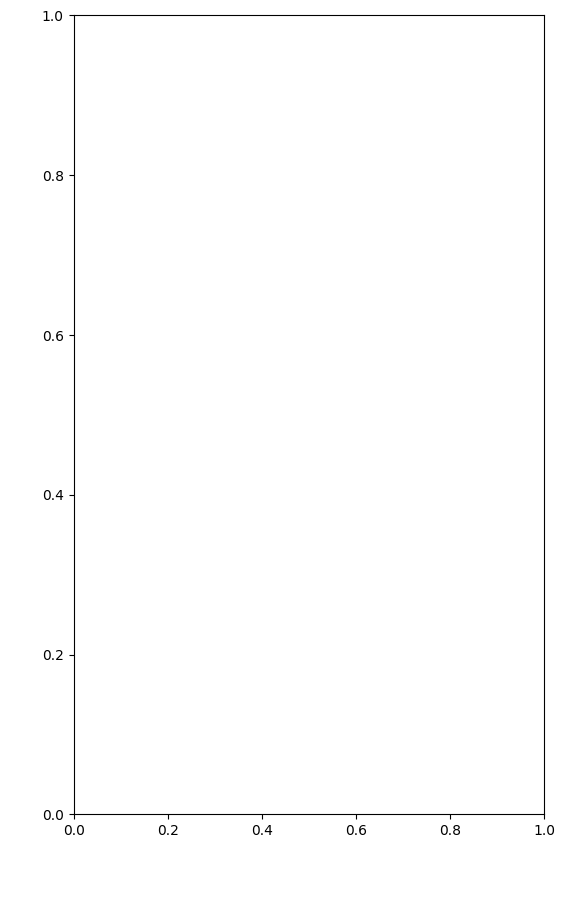

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from matplotlib.ticker import EngFormatter, MultipleLocator
from matplotlib.transforms import blended_transform_factory
import matplotlib.transforms as mtransforms
from matplotlib.cm import ScalarMappable


def format_ticks(ax):
    """格式化坐标轴刻度"""
    formatter = EngFormatter(unit='', places=0)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

### -------------- 2. 构建 2×2 的 gridspec --------------
# 计算数据范围比例，调整图形比例
data_width = end2 - start2   # x轴数据范围
data_height = end1 - start1  # y轴数据范围
aspect_ratio = data_width / data_height

# 根据数据比例调整figure大小
if aspect_ratio > 1:
    # x轴更长，增加figure宽度
    fig_width = 7 * aspect_ratio ** 0.5
    fig_height = 7 / aspect_ratio ** 0.5
else:
    # y轴更长，增加figure高度
    fig_width = 7 * aspect_ratio ** 0.5
    fig_height = 7 / aspect_ratio ** 0.5

fig = plt.figure(figsize=(fig_width, fig_height), constrained_layout=True)
gs = fig.add_gridspec(
    nrows=2, ncols=2,
    width_ratios=[0.05, 1],      # 压缩左侧 y-bar 宽度：从0.25改为0.15
    height_ratios=[1, 0.05],     # 压缩下方 x-bar 高度：从0.25改为0.15
    wspace=0.02, hspace=0.02     # 增加一点间距，避免太紧密
)

ax_mat = fig.add_subplot(gs[0, 1])      # 主热图
ax_ybar = fig.add_subplot(gs[0, 0], sharey=ax_mat)  # 左侧 y-bar
ax_xbar = fig.add_subplot(gs[1, 1], sharex=ax_mat)  # 下方 x-bar

# 隐藏 bar 轴坐标刻度，只保留可见的 bar
for ax in [ax_ybar, ax_xbar]:
    ax.axis('off')

### -------------- 3. 画主 Hi-C 热图 --------------
norm_bal = LogNorm(vmin=1, vmax=50)
im = ax_mat.matshow(
    Homo_bal_AoI_rpb_matrix,
    norm=norm_bal,
    cmap='YlOrRd',
    extent=(start2, end2, end1, start1),   # 注意 y 轴反向
    aspect='auto'  # 关键：让matplotlib自动调整纵横比
)

ax_mat.set_title(f'Homo Balanced contacts\n{chr1} vs {chr2}', pad=10)
ax_mat.set_xlabel(f'{chr2} position (bp)')
ax_mat.set_ylabel(f'{chr1} position (bp)')
format_ticks(ax_mat)

# ---------------------------------
# 4. 在 bar 轴上画 OR-cluster 红条
# ---------------------------------

# 重要：先设置坐标轴范围，确保与主图一致
ax_mat.set_xlim(start2, end2)
ax_mat.set_ylim(end1, start1)  # 注意y轴是反向的

# 确保bar轴与主图范围完全一致
ax_ybar.set_ylim(ax_mat.get_ylim())
ax_xbar.set_xlim(ax_mat.get_xlim())

# 强制更新坐标轴
fig.canvas.draw_idle()
# 4.2 y-bar: 标注 cluster（crimson）和 GI（darkgreen）
trans_ybar = blended_transform_factory(ax_ybar.transAxes, ax_ybar.transData)

# cluster（左侧）
for _, row in region1_clusters.iterrows():
    ax_ybar.add_patch(Rectangle(
        (0.2, row['bin_start']),
        0.6,
        row['bin_end'] - row['bin_start'],
        transform=trans_ybar,
        color='crimson',
        clip_on=False
    ))

# GI（左侧）
for _, row in region1_GI.iterrows():
    ax_ybar.add_patch(Rectangle(
        (0.2, row['start']),
        0.6,
        row['end'] - row['start'],
        transform=trans_ybar,
        color='darkgreen',
        clip_on=False
    ))

# 4.3 x-bar: 标注 cluster（crimson）和 GI（darkgreen）
trans_xbar = blended_transform_factory(ax_xbar.transData, ax_xbar.transAxes)

# cluster（下方）
for _, row in region2_clusters.iterrows():
    ax_xbar.add_patch(Rectangle(
        (row['bin_start'], 0.2),
        row['bin_end'] - row['bin_start'],
        0.6,
        transform=trans_xbar,
        color='crimson',
        clip_on=False
    ))

# GI（下方）
for _, row in region2_GI.iterrows():
    ax_xbar.add_patch(Rectangle(
        (row['start'], 0.2),
        row['end'] - row['start'],
        0.6,
        transform=trans_xbar,
        color='darkgreen',
        clip_on=False
    ))
    
# 创建 ScalarMappable 用于 colorbar
sm = ScalarMappable(norm=norm_bal, cmap='YlOrRd')
sm.set_array([])  # 避免报错

# 添加 colorbar 到主图右上角
cbar = fig.colorbar(sm, ax=ax_mat, fraction=0.046, pad=0.04)
cbar.set_label('Balanced contacts (per billion)', fontsize=12)


# 强制刷新显示
fig.canvas.draw_idle()
plt.savefig('../plots_v1/chr2_chr9_cluster_trans_interaction_Homo_example_50kb.pdf', dpi=300)

plt.show()

# 调试输出
print("主图 x 轴范围:", ax_mat.get_xlim())
print("x-bar x 轴范围:", ax_xbar.get_xlim())
print("主图 y 轴范围:", ax_mat.get_ylim())
print("y-bar y 轴范围:", ax_ybar.get_ylim())

In [24]:
start_1, end_1 = 84000000, 92000000
region_1 = ('chr2', start_1, end_1)
start_3, end_3 = 101000000, 106000000
region_3 = ('chr7', start_3, end_3)

In [25]:
# 获取在 region_1 和 region_3 中的 cluster 及其 bin 的位置
chr1, start1, end1 = region_1
chr3, start3, end3 = region_3

# 筛选两个染色体中、落入绘图区域的 cluster
region1_clusters = cluster_to_bin_mapping_all_50kb[
    (cluster_to_bin_mapping_all_50kb['cluster_chrom'] == chr1) &
    (cluster_to_bin_mapping_all_50kb['cluster_start'] < end1) &
    (cluster_to_bin_mapping_all_50kb['cluster_end'] > start1)
]
print(region1_clusters)

region3_clusters = cluster_to_bin_mapping_all_50kb[
    (cluster_to_bin_mapping_all_50kb['cluster_chrom'] == chr3) &
    (cluster_to_bin_mapping_all_50kb['cluster_start'] < end3) &
    (cluster_to_bin_mapping_all_50kb['cluster_end'] > start3)
]

print(region3_clusters)

# 获取在 region_1 和 region_3 中的 cluster 及其 bin 的位置
chr1, start1, end1 = region_1
chr3, start3, end3 = region_3

# 筛选两个染色体中、落入绘图区域的 cluster
region1_GI = GI_bed[
    (GI_bed['chrom'] == chr1) &
    (GI_bed['start'] < end1) &
    (GI_bed['end'] > start1)
]
print(region1_GI)

region3_GI = GI_bed[
    (GI_bed['chrom'] == chr3) &
    (GI_bed['start'] < end3) &
    (GI_bed['end'] > start3)
]
print(region3_GI)


     cluster_idx cluster_chrom  cluster_start  cluster_end  cluster_length  \
57             3          chr2       85330779     90403897         5073118   
58             3          chr2       85330779     90403897         5073118   
59             3          chr2       85330779     90403897         5073118   
60             3          chr2       85330779     90403897         5073118   
61             3          chr2       85330779     90403897         5073118   
..           ...           ...            ...          ...             ...   
155            3          chr2       85330779     90403897         5073118   
156            3          chr2       85330779     90403897         5073118   
157            3          chr2       85330779     90403897         5073118   
158            3          chr2       85330779     90403897         5073118   
159            3          chr2       85330779     90403897         5073118   

     bin_idx bin_chrom  bin_start   bin_end  bin_length  overla

In [40]:
Het_bal_AoI_2 = Het_clr_50kb.matrix(balance=True).fetch(region_1, region_3)

Het_bal_AoI_2_rpb_matrix = (Het_bal_AoI_2 / Het_total_balanced_count_50kb) * 1e9

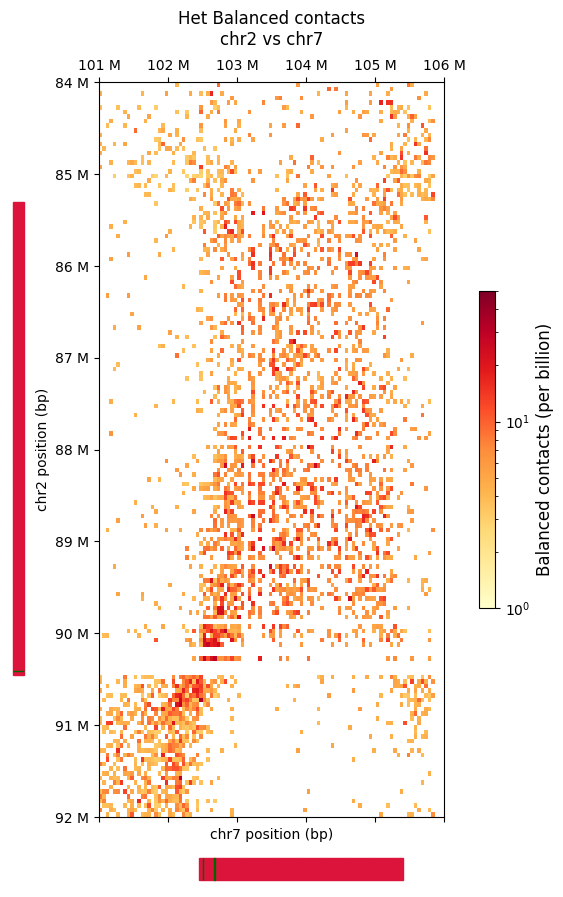

主图 x 轴范围: (np.float64(101000000.0), np.float64(106000000.0))
x-bar x 轴范围: (np.float64(101000000.0), np.float64(106000000.0))
主图 y 轴范围: (np.float64(92000000.0), np.float64(84000000.0))
y-bar y 轴范围: (np.float64(92000000.0), np.float64(84000000.0))


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from matplotlib.ticker import EngFormatter, MultipleLocator
from matplotlib.transforms import blended_transform_factory
import matplotlib.transforms as mtransforms
from matplotlib.cm import ScalarMappable


def format_ticks(ax):
    """格式化坐标轴刻度"""
    formatter = EngFormatter(unit='', places=0)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

### -------------- 2. 构建 2×2 的 gridspec --------------
# 计算数据范围比例，调整图形比例
data_width = end3 - start3   # x轴数据范围
data_height = end1 - start1  # y轴数据范围
aspect_ratio = data_width / data_height

# 根据数据比例调整figure大小
if aspect_ratio > 1:
    # x轴更长，增加figure宽度
    fig_width = 7 * aspect_ratio ** 0.5
    fig_height = 7 / aspect_ratio ** 0.5
else:
    # y轴更长，增加figure高度
    fig_width = 7 * aspect_ratio ** 0.5
    fig_height = 7 / aspect_ratio ** 0.5

fig = plt.figure(figsize=(fig_width, fig_height), constrained_layout=True)
gs = fig.add_gridspec(
    nrows=2, ncols=2,
    width_ratios=[0.05, 1],      # 压缩左侧 y-bar 宽度：从0.25改为0.15
    height_ratios=[1, 0.05],     # 压缩下方 x-bar 高度：从0.25改为0.15
    wspace=0.02, hspace=0.02     # 增加一点间距，避免太紧密
)

ax_mat = fig.add_subplot(gs[0, 1])      # 主热图
ax_ybar = fig.add_subplot(gs[0, 0], sharey=ax_mat)  # 左侧 y-bar
ax_xbar = fig.add_subplot(gs[1, 1], sharex=ax_mat)  # 下方 x-bar

# 隐藏 bar 轴坐标刻度，只保留可见的 bar
for ax in [ax_ybar, ax_xbar]:
    ax.axis('off')

### -------------- 3. 画主 Hi-C 热图 --------------
norm_bal = LogNorm(vmin=1, vmax=50)
im = ax_mat.matshow(
    Het_bal_AoI_2_rpb_matrix,
    norm=norm_bal,
    cmap='YlOrRd',
    extent=(start3, end3, end1, start1),   # 注意 y 轴反向
    aspect='auto'  # 关键：让matplotlib自动调整纵横比
)

ax_mat.set_title(f'Het Balanced contacts\n{chr1} vs {chr3}', pad=10)
ax_mat.set_xlabel(f'{chr3} position (bp)')
ax_mat.set_ylabel(f'{chr1} position (bp)')
format_ticks(ax_mat)

# ---------------------------------
# 4. 在 bar 轴上画 OR-cluster 红条
# ---------------------------------

# 重要：先设置坐标轴范围，确保与主图一致
ax_mat.set_xlim(start3, end3)
ax_mat.set_ylim(end1, start1)  # 注意y轴是反向的

# 确保bar轴与主图范围完全一致
ax_ybar.set_ylim(ax_mat.get_ylim())
ax_xbar.set_xlim(ax_mat.get_xlim())

# 强制更新坐标轴
fig.canvas.draw_idle()
# 4.2 y-bar: 标注 cluster（crimson）和 GI（darkgreen）
trans_ybar = blended_transform_factory(ax_ybar.transAxes, ax_ybar.transData)

# cluster（左侧）
for _, row in region1_clusters.iterrows():
    ax_ybar.add_patch(Rectangle(
        (0.2, row['bin_start']),
        0.6,
        row['bin_end'] - row['bin_start'],
        transform=trans_ybar,
        color='crimson',
        clip_on=False
    ))

# GI（左侧）
for _, row in region1_GI.iterrows():
    ax_ybar.add_patch(Rectangle(
        (0.2, row['start']),
        0.6,
        row['end'] - row['start'],
        transform=trans_ybar,
        color='darkgreen',
        clip_on=False
    ))

# 4.3 x-bar: 标注 cluster（crimson）和 GI（darkgreen）
trans_xbar = blended_transform_factory(ax_xbar.transData, ax_xbar.transAxes)

# cluster（下方）
for _, row in region3_clusters.iterrows():
    ax_xbar.add_patch(Rectangle(
        (row['bin_start'], 0.2),
        row['bin_end'] - row['bin_start'],
        0.6,
        transform=trans_xbar,
        color='crimson',
        clip_on=False
    ))

# GI（下方）
for _, row in region3_GI.iterrows():
    ax_xbar.add_patch(Rectangle(
        (row['start'], 0.2),
        row['end'] - row['start'],
        0.6,
        transform=trans_xbar,
        color='darkgreen',
        clip_on=False
    ))
    
# 创建 ScalarMappable 用于 colorbar
sm = ScalarMappable(norm=norm_bal, cmap='YlOrRd')
sm.set_array([])  # 避免报错

# 添加 colorbar 到主图右上角
cbar = fig.colorbar(sm, ax=ax_mat, fraction=0.046, pad=0.04)
cbar.set_label('Balanced contacts (per billion)', fontsize=12)

# 强制刷新显示
fig.canvas.draw_idle()
plt.savefig('../plots_v1/chr2_chr7_cluster_trans_interaction_Het_example_50kb.pdf', dpi=300)
plt.show()

# 调试输出
print("主图 x 轴范围:", ax_mat.get_xlim())
print("x-bar x 轴范围:", ax_xbar.get_xlim())
print("主图 y 轴范围:", ax_mat.get_ylim())
print("y-bar y 轴范围:", ax_ybar.get_ylim())

In [42]:
Homo_bal_AoI_2 = Homo_clr_50kb.matrix(balance=True).fetch(region_1, region_3)

Homo_bal_AoI_2_rpb_matrix = (Homo_bal_AoI_2 / Homo_total_balanced_count_50kb) * 1e9

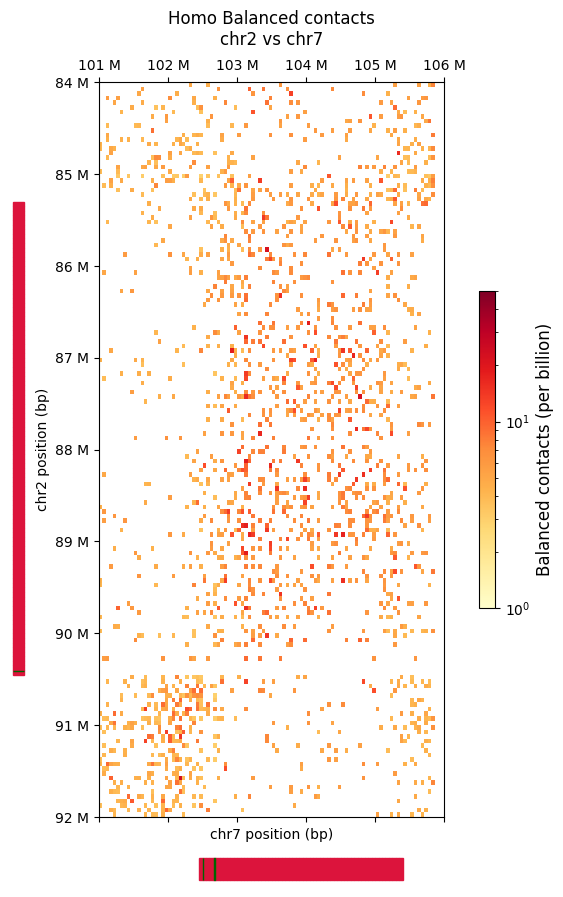

主图 x 轴范围: (np.float64(101000000.0), np.float64(106000000.0))
x-bar x 轴范围: (np.float64(101000000.0), np.float64(106000000.0))
主图 y 轴范围: (np.float64(92000000.0), np.float64(84000000.0))
y-bar y 轴范围: (np.float64(92000000.0), np.float64(84000000.0))


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from matplotlib.ticker import EngFormatter, MultipleLocator
from matplotlib.transforms import blended_transform_factory
import matplotlib.transforms as mtransforms
from matplotlib.cm import ScalarMappable


def format_ticks(ax):
    """格式化坐标轴刻度"""
    formatter = EngFormatter(unit='', places=0)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

### -------------- 2. 构建 2×2 的 gridspec --------------
# 计算数据范围比例，调整图形比例
data_width = end3 - start3   # x轴数据范围
data_height = end1 - start1  # y轴数据范围
aspect_ratio = data_width / data_height

# 根据数据比例调整figure大小
if aspect_ratio > 1:
    # x轴更长，增加figure宽度
    fig_width = 7 * aspect_ratio ** 0.5
    fig_height = 7 / aspect_ratio ** 0.5
else:
    # y轴更长，增加figure高度
    fig_width = 7 * aspect_ratio ** 0.5
    fig_height = 7 / aspect_ratio ** 0.5

fig = plt.figure(figsize=(fig_width, fig_height), constrained_layout=True)
gs = fig.add_gridspec(
    nrows=2, ncols=2,
    width_ratios=[0.05, 1],      # 压缩左侧 y-bar 宽度：从0.25改为0.15
    height_ratios=[1, 0.05],     # 压缩下方 x-bar 高度：从0.25改为0.15
    wspace=0.02, hspace=0.02     # 增加一点间距，避免太紧密
)

ax_mat = fig.add_subplot(gs[0, 1])      # 主热图
ax_ybar = fig.add_subplot(gs[0, 0], sharey=ax_mat)  # 左侧 y-bar
ax_xbar = fig.add_subplot(gs[1, 1], sharex=ax_mat)  # 下方 x-bar

# 隐藏 bar 轴坐标刻度，只保留可见的 bar
for ax in [ax_ybar, ax_xbar]:
    ax.axis('off')

### -------------- 3. 画主 Hi-C 热图 --------------
norm_bal = LogNorm(vmin=1, vmax=50)
im = ax_mat.matshow(
    Homo_bal_AoI_2_rpb_matrix,
    norm=norm_bal,
    cmap='YlOrRd',
    extent=(start3, end3, end1, start1),   # 注意 y 轴反向
    aspect='auto'  # 关键：让matplotlib自动调整纵横比
)

ax_mat.set_title(f'Homo Balanced contacts\n{chr1} vs {chr3}', pad=10)
ax_mat.set_xlabel(f'{chr3} position (bp)')
ax_mat.set_ylabel(f'{chr1} position (bp)')
format_ticks(ax_mat)

# ---------------------------------
# 4. 在 bar 轴上画 OR-cluster 红条
# ---------------------------------

# 重要：先设置坐标轴范围，确保与主图一致
ax_mat.set_xlim(start3, end3)
ax_mat.set_ylim(end1, start1)  # 注意y轴是反向的

# 确保bar轴与主图范围完全一致
ax_ybar.set_ylim(ax_mat.get_ylim())
ax_xbar.set_xlim(ax_mat.get_xlim())

# 强制更新坐标轴
fig.canvas.draw_idle()
# 4.2 y-bar: 标注 cluster（crimson）和 GI（darkgreen）
trans_ybar = blended_transform_factory(ax_ybar.transAxes, ax_ybar.transData)

# cluster（左侧）
for _, row in region1_clusters.iterrows():
    ax_ybar.add_patch(Rectangle(
        (0.2, row['bin_start']),
        0.6,
        row['bin_end'] - row['bin_start'],
        transform=trans_ybar,
        color='crimson',
        clip_on=False
    ))

# GI（左侧）
for _, row in region1_GI.iterrows():
    ax_ybar.add_patch(Rectangle(
        (0.2, row['start']),
        0.6,
        row['end'] - row['start'],
        transform=trans_ybar,
        color='darkgreen',
        clip_on=False
    ))

# 4.3 x-bar: 标注 cluster（crimson）和 GI（darkgreen）
trans_xbar = blended_transform_factory(ax_xbar.transData, ax_xbar.transAxes)

# cluster（下方）
for _, row in region3_clusters.iterrows():
    ax_xbar.add_patch(Rectangle(
        (row['bin_start'], 0.2),
        row['bin_end'] - row['bin_start'],
        0.6,
        transform=trans_xbar,
        color='crimson',
        clip_on=False
    ))

# GI（下方）
for _, row in region3_GI.iterrows():
    ax_xbar.add_patch(Rectangle(
        (row['start'], 0.2),
        row['end'] - row['start'],
        0.6,
        transform=trans_xbar,
        color='darkgreen',
        clip_on=False
    ))
    
# 创建 ScalarMappable 用于 colorbar
sm = ScalarMappable(norm=norm_bal, cmap='YlOrRd')
sm.set_array([])  # 避免报错

# 添加 colorbar 到主图右上角
cbar = fig.colorbar(sm, ax=ax_mat, fraction=0.046, pad=0.04)
cbar.set_label('Balanced contacts (per billion)', fontsize=12)

# 强制刷新显示
fig.canvas.draw_idle()
plt.savefig('../plots_v1/chr2_chr7_cluster_trans_interaction_Homo_example_50kb.pdf', dpi=300)
plt.show()

# 调试输出
print("主图 x 轴范围:", ax_mat.get_xlim())
print("x-bar x 轴范围:", ax_xbar.get_xlim())
print("主图 y 轴范围:", ax_mat.get_ylim())
print("y-bar y 轴范围:", ax_ybar.get_ylim())

In [62]:
start_1, end_1 = 84000000, 92000000
region_1 = ('chr2', start_1, end_1) 
start_4, end_4 = 106000000, 110000000
region_4 = ('chr7', start_4, end_4)

In [63]:
# 获取在 region_1 和 region_4 中的 cluster 及其 bin 的位置
chr1, start1, end1 = region_1
chr4, start4, end4 = region_4

# 筛选两个染色体中、落入绘图区域的 cluster
region1_clusters = cluster_to_bin_mapping_all_50kb[
    (cluster_to_bin_mapping_all_50kb['cluster_chrom'] == chr1) &
    (cluster_to_bin_mapping_all_50kb['cluster_start'] < end1) &
    (cluster_to_bin_mapping_all_50kb['cluster_end'] > start1)
]
print(region1_clusters)

region4_clusters = cluster_to_bin_mapping_all_50kb[
    (cluster_to_bin_mapping_all_50kb['cluster_chrom'] == chr4) &
    (cluster_to_bin_mapping_all_50kb['cluster_start'] < end4) &
    (cluster_to_bin_mapping_all_50kb['cluster_end'] > start4)
]

print(region4_clusters)

# 获取在 region_1 和 region_4 中的 cluster 及其 bin 的位置
chr1, start1, end1 = region_1
chr4, start4, end4 = region_4

# 筛选两个染色体中、落入绘图区域的 cluster
region1_GI = GI_bed[
    (GI_bed['chrom'] == chr1) &
    (GI_bed['start'] < end1) &
    (GI_bed['end'] > start1)
]
print(region1_GI)

region4_GI = GI_bed[
    (GI_bed['chrom'] == chr4) &
    (GI_bed['start'] < end4) &
    (GI_bed['end'] > start4)
]
print(region4_GI)

Het_bal_AoI_3 = Het_clr_50kb.matrix(balance=True).fetch(region_1, region_4)

Het_bal_AoI_3_rpb_matrix = (Het_bal_AoI_3 / Het_total_balanced_count_50kb) * 1e9


     cluster_idx cluster_chrom  cluster_start  cluster_end  cluster_length  \
57             3          chr2       85330779     90403897         5073118   
58             3          chr2       85330779     90403897         5073118   
59             3          chr2       85330779     90403897         5073118   
60             3          chr2       85330779     90403897         5073118   
61             3          chr2       85330779     90403897         5073118   
..           ...           ...            ...          ...             ...   
155            3          chr2       85330779     90403897         5073118   
156            3          chr2       85330779     90403897         5073118   
157            3          chr2       85330779     90403897         5073118   
158            3          chr2       85330779     90403897         5073118   
159            3          chr2       85330779     90403897         5073118   

     bin_idx bin_chrom  bin_start   bin_end  bin_length  overla

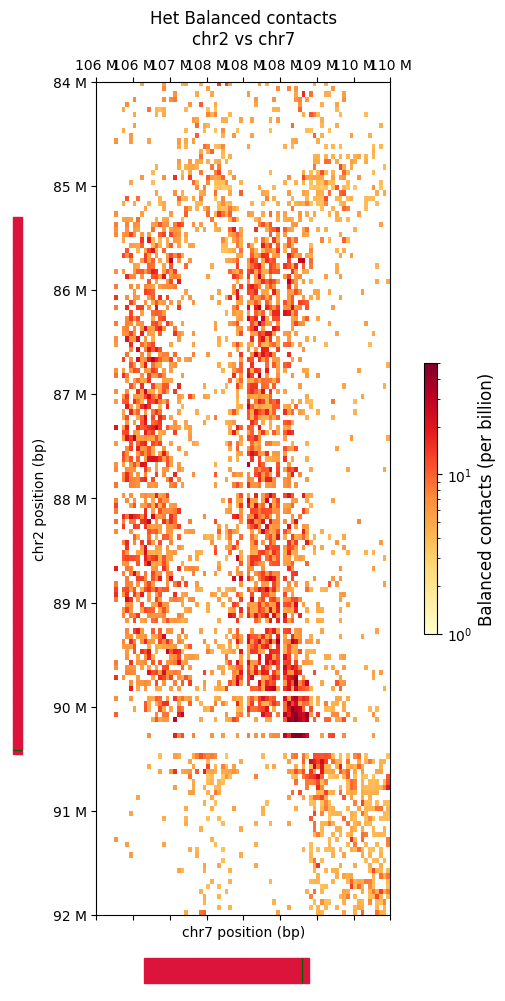

主图 x 轴范围: (np.float64(106000000.0), np.float64(110000000.0))
x-bar x 轴范围: (np.float64(106000000.0), np.float64(110000000.0))
主图 y 轴范围: (np.float64(92000000.0), np.float64(84000000.0))
y-bar y 轴范围: (np.float64(92000000.0), np.float64(84000000.0))


In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from matplotlib.ticker import EngFormatter, MultipleLocator
from matplotlib.transforms import blended_transform_factory
import matplotlib.transforms as mtransforms
from matplotlib.cm import ScalarMappable


def format_ticks(ax):
    """格式化坐标轴刻度"""
    formatter = EngFormatter(unit='', places=0)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

### -------------- 2. 构建 2×2 的 gridspec --------------
# 计算数据范围比例，调整图形比例
data_width = end4 - start4   # x轴数据范围
data_height = end1 - start1  # y轴数据范围
aspect_ratio = data_width / data_height

# 根据数据比例调整figure大小
if aspect_ratio > 1:
    # x轴更长，增加figure宽度
    fig_width = 7 * aspect_ratio ** 0.5
    fig_height = 7 / aspect_ratio ** 0.5
else:
    # y轴更长，增加figure高度
    fig_width = 7 * aspect_ratio ** 0.5
    fig_height = 7 / aspect_ratio ** 0.5

fig = plt.figure(figsize=(fig_width, fig_height), constrained_layout=True)
gs = fig.add_gridspec(
    nrows=2, ncols=2,
    width_ratios=[0.05, 1],      # 压缩左侧 y-bar 宽度：从0.25改为0.15
    height_ratios=[1, 0.05],     # 压缩下方 x-bar 高度：从0.25改为0.15
    wspace=0.02, hspace=0.02     # 增加一点间距，避免太紧密
)

ax_mat = fig.add_subplot(gs[0, 1])      # 主热图
ax_ybar = fig.add_subplot(gs[0, 0], sharey=ax_mat)  # 左侧 y-bar
ax_xbar = fig.add_subplot(gs[1, 1], sharex=ax_mat)  # 下方 x-bar

# 隐藏 bar 轴坐标刻度，只保留可见的 bar
for ax in [ax_ybar, ax_xbar]:
    ax.axis('off')

### -------------- 3. 画主 Hi-C 热图 --------------
norm_bal = LogNorm(vmin=1, vmax=50)
im = ax_mat.matshow(
    Het_bal_AoI_3_rpb_matrix,
    norm=norm_bal,
    cmap='YlOrRd',
    extent=(start4, end4, end1, start1),   # 注意 y 轴反向
    aspect='auto'  # 关键：让matplotlib自动调整纵横比
)

ax_mat.set_title(f'Het Balanced contacts\n{chr1} vs {chr4}', pad=10)
ax_mat.set_xlabel(f'{chr4} position (bp)')
ax_mat.set_ylabel(f'{chr1} position (bp)')
format_ticks(ax_mat)

# ---------------------------------
# 4. 在 bar 轴上画 OR-cluster 红条
# ---------------------------------

# 重要：先设置坐标轴范围，确保与主图一致
ax_mat.set_xlim(start4, end4)
ax_mat.set_ylim(end1, start1)  # 注意y轴是反向的

# 确保bar轴与主图范围完全一致
ax_ybar.set_ylim(ax_mat.get_ylim())
ax_xbar.set_xlim(ax_mat.get_xlim())

# 强制更新坐标轴
fig.canvas.draw_idle()
# 4.2 y-bar: 标注 cluster（crimson）和 GI（darkgreen）
trans_ybar = blended_transform_factory(ax_ybar.transAxes, ax_ybar.transData)

# cluster（左侧）
for _, row in region1_clusters.iterrows():
    ax_ybar.add_patch(Rectangle(
        (0.2, row['bin_start']),
        0.6,
        row['bin_end'] - row['bin_start'],
        transform=trans_ybar,
        color='crimson',
        clip_on=False
    ))

# GI（左侧）
for _, row in region1_GI.iterrows():
    ax_ybar.add_patch(Rectangle(
        (0.2, row['start']),
        0.6,
        row['end'] - row['start'],
        transform=trans_ybar,
        color='darkgreen',
        clip_on=False
    ))

# 4.3 x-bar: 标注 cluster（crimson）和 GI（darkgreen）
trans_xbar = blended_transform_factory(ax_xbar.transData, ax_xbar.transAxes)

# cluster（下方）
for _, row in region4_clusters.iterrows():
    ax_xbar.add_patch(Rectangle(
        (row['bin_start'], 0.2),
        row['bin_end'] - row['bin_start'],
        0.6,
        transform=trans_xbar,
        color='crimson',
        clip_on=False
    ))

# GI（下方）
for _, row in region4_GI.iterrows():
    ax_xbar.add_patch(Rectangle(
        (row['start'], 0.2),
        row['end'] - row['start'],
        0.6,
        transform=trans_xbar,
        color='darkgreen',
        clip_on=False
    ))
    
# 创建 ScalarMappable 用于 colorbar
sm = ScalarMappable(norm=norm_bal, cmap='YlOrRd')
sm.set_array([])  # 避免报错

# 添加 colorbar 到主图右上角
cbar = fig.colorbar(sm, ax=ax_mat, fraction=0.046, pad=0.04)
cbar.set_label('Balanced contacts (per billion)', fontsize=12)

# 强制刷新显示
fig.canvas.draw_idle()
plt.savefig('../plots_v1/chr2_chr7_cluster_trans_interaction_Het_example_2_50kb.pdf', dpi=300)
plt.show()

# 调试输出
print("主图 x 轴范围:", ax_mat.get_xlim())
print("x-bar x 轴范围:", ax_xbar.get_xlim())
print("主图 y 轴范围:", ax_mat.get_ylim())
print("y-bar y 轴范围:", ax_ybar.get_ylim())

In [65]:
Homo_bal_AoI_3 = Homo_clr_50kb.matrix(balance=True).fetch(region_1, region_4)

Homo_bal_AoI_3_rpb_matrix = (Homo_bal_AoI_3 / Homo_total_balanced_count_50kb) * 1e9


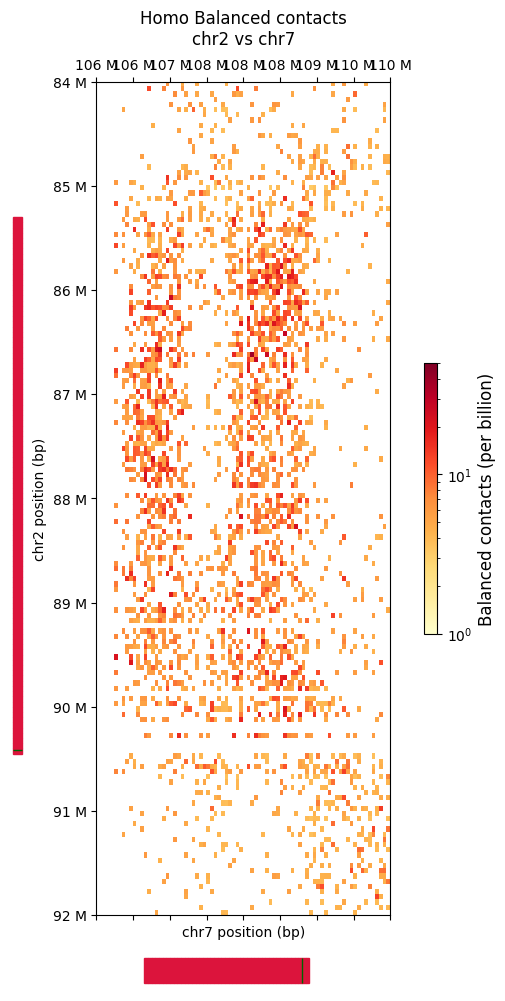

主图 x 轴范围: (np.float64(106000000.0), np.float64(110000000.0))
x-bar x 轴范围: (np.float64(106000000.0), np.float64(110000000.0))
主图 y 轴范围: (np.float64(92000000.0), np.float64(84000000.0))
y-bar y 轴范围: (np.float64(92000000.0), np.float64(84000000.0))


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from matplotlib.ticker import EngFormatter, MultipleLocator
from matplotlib.transforms import blended_transform_factory
import matplotlib.transforms as mtransforms
from matplotlib.cm import ScalarMappable


def format_ticks(ax):
    """格式化坐标轴刻度"""
    formatter = EngFormatter(unit='', places=0)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

### -------------- 2. 构建 2×2 的 gridspec --------------
# 计算数据范围比例，调整图形比例
data_width = end4 - start4   # x轴数据范围
data_height = end1 - start1  # y轴数据范围
aspect_ratio = data_width / data_height

# 根据数据比例调整figure大小
if aspect_ratio > 1:
    # x轴更长，增加figure宽度
    fig_width = 7 * aspect_ratio ** 0.5
    fig_height = 7 / aspect_ratio ** 0.5
else:
    # y轴更长，增加figure高度
    fig_width = 7 * aspect_ratio ** 0.5
    fig_height = 7 / aspect_ratio ** 0.5

fig = plt.figure(figsize=(fig_width, fig_height), constrained_layout=True)
gs = fig.add_gridspec(
    nrows=2, ncols=2,
    width_ratios=[0.05, 1],      # 压缩左侧 y-bar 宽度：从0.25改为0.15
    height_ratios=[1, 0.05],     # 压缩下方 x-bar 高度：从0.25改为0.15
    wspace=0.02, hspace=0.02     # 增加一点间距，避免太紧密
)

ax_mat = fig.add_subplot(gs[0, 1])      # 主热图
ax_ybar = fig.add_subplot(gs[0, 0], sharey=ax_mat)  # 左侧 y-bar
ax_xbar = fig.add_subplot(gs[1, 1], sharex=ax_mat)  # 下方 x-bar

# 隐藏 bar 轴坐标刻度，只保留可见的 bar
for ax in [ax_ybar, ax_xbar]:
    ax.axis('off')

### -------------- 3. 画主 Hi-C 热图 --------------
norm_bal = LogNorm(vmin=1, vmax=50)
im = ax_mat.matshow(
    Homo_bal_AoI_3_rpb_matrix,
    norm=norm_bal,
    cmap='YlOrRd',
    extent=(start4, end4, end1, start1),   # 注意 y 轴反向
    aspect='auto'  # 关键：让matplotlib自动调整纵横比
)

ax_mat.set_title(f'Homo Balanced contacts\n{chr1} vs {chr4}', pad=10)
ax_mat.set_xlabel(f'{chr4} position (bp)')
ax_mat.set_ylabel(f'{chr1} position (bp)')
format_ticks(ax_mat)

# ---------------------------------
# 4. 在 bar 轴上画 OR-cluster 红条
# ---------------------------------

# 重要：先设置坐标轴范围，确保与主图一致
ax_mat.set_xlim(start4, end4)
ax_mat.set_ylim(end1, start1)  # 注意y轴是反向的

# 确保bar轴与主图范围完全一致
ax_ybar.set_ylim(ax_mat.get_ylim())
ax_xbar.set_xlim(ax_mat.get_xlim())

# 强制更新坐标轴
fig.canvas.draw_idle()
# 4.2 y-bar: 标注 cluster（crimson）和 GI（darkgreen）
trans_ybar = blended_transform_factory(ax_ybar.transAxes, ax_ybar.transData)

# cluster（左侧）
for _, row in region1_clusters.iterrows():
    ax_ybar.add_patch(Rectangle(
        (0.2, row['bin_start']),
        0.6,
        row['bin_end'] - row['bin_start'],
        transform=trans_ybar,
        color='crimson',
        clip_on=False
    ))

# GI（左侧）
for _, row in region1_GI.iterrows():
    ax_ybar.add_patch(Rectangle(
        (0.2, row['start']),
        0.6,
        row['end'] - row['start'],
        transform=trans_ybar,
        color='darkgreen',
        clip_on=False
    ))

# 4.3 x-bar: 标注 cluster（crimson）和 GI（darkgreen）
trans_xbar = blended_transform_factory(ax_xbar.transData, ax_xbar.transAxes)

# cluster（下方）
for _, row in region4_clusters.iterrows():
    ax_xbar.add_patch(Rectangle(
        (row['bin_start'], 0.2),
        row['bin_end'] - row['bin_start'],
        0.6,
        transform=trans_xbar,
        color='crimson',
        clip_on=False
    ))

# GI（下方）
for _, row in region4_GI.iterrows():
    ax_xbar.add_patch(Rectangle(
        (row['start'], 0.2),
        row['end'] - row['start'],
        0.6,
        transform=trans_xbar,
        color='darkgreen',
        clip_on=False
    ))
    
# 创建 ScalarMappable 用于 colorbar
sm = ScalarMappable(norm=norm_bal, cmap='YlOrRd')
sm.set_array([])  # 避免报错

# 添加 colorbar 到主图右上角
cbar = fig.colorbar(sm, ax=ax_mat, fraction=0.046, pad=0.04)
cbar.set_label('Balanced contacts (per billion)', fontsize=12)

# 强制刷新显示
fig.canvas.draw_idle()
plt.savefig('../plots_v1/chr2_chr7_cluster_trans_interaction_Homo_example_2_50kb.pdf', dpi=300)
plt.show()

# 调试输出
print("主图 x 轴范围:", ax_mat.get_xlim())
print("x-bar x 轴范围:", ax_xbar.get_xlim())
print("主图 y 轴范围:", ax_mat.get_ylim())
print("y-bar y 轴范围:", ax_ybar.get_ylim())